<a href="https://colab.research.google.com/github/jesskw1/3D/blob/main/DelphiniumClassificationCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip '/content/gdrive/MyDrive/delphinium_d.zip' > /dev/null

In [ ]:
data_dir = 'delphinium_d'

# define batch size
batch_size = 25

# define transforms
# training (with random flips and rotation)
train_transform = transforms.Compose([transforms.Resize(236), # resize to 236x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(degrees=(180, 180)),
                                transforms.ToTensor(), # convert data to torch.FloatTensor                             
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# validation and testing
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

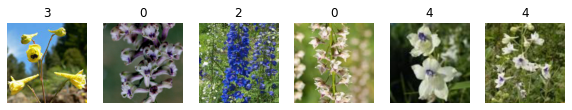

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)


fig, axes = plt.subplots(figsize=(10,6), ncols=6)
for ii in range(6):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 

In [ ]:
import torch.nn as nn
import torchvision.models as models

# load a pre-trained ResNet network with 18 layers
model = models.densenet201(pretrained=True)

num_ftrs = model.classifier.in_features
# replace the final layer so that the output is number of classes
model.classifier = nn.Linear(num_ftrs, 6)


if train_on_gpu:
    model.cuda()

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# number of epochs to train the model
n_epochs = 25

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'densenet201_model_fine_tune_aug.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/densenet201_model_fine_tune_aug.pt') # save in google drive
        valid_loss_min = valid_loss

RuntimeError: ignored

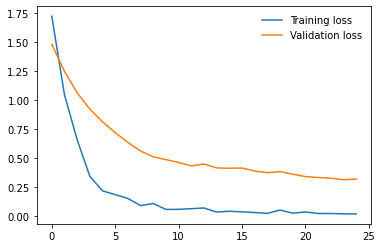

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
model.load_state_dict(torch.load('densenet201_model_fine_tune_aug.pt'))

<All keys matched successfully>

In [ ]:
# Load previously trained model

# create a new model with ResNet18 architecture
myModel = models.densenet201(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.classifier.in_features
# replace the final layer so that the output is four classes
myModel.classifier = nn.Linear(num_ftrs, 6)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/densenet201_model_fine_tune_aug.pt'))
# remove the final layer so the output of the network is now a 512 feature vector
myModel = nn.Sequential(*list(myModel.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    myModel.cuda()

In [ ]:
imagenetModel = models.densenet201(pretrained=True)
imagenetModel = nn.Sequential(*list(imagenetModel.children())[:-1])

if train_on_gpu:
    imagenetModel.cuda()

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
imageNet_feats = imagenetModel(images)
delphinium_feats = myModel(images)

# put on cpu, convert to numpy array and squeeze to batchsize x 512
imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
delphinium_feats = np.squeeze(delphinium_feats.cpu().detach().numpy())

labels = labels.numpy()

imageNet_feats = imageNet_feats[:, :, 0, 0]
delphinium_feats = delphinium_feats[:, :, 0, 0]



print(imageNet_feats.shape)
print(delphinium_feats.shape)
print(labels)

(20, 1920)
(20, 1920)
[5 2 2 3 5 3 3 4 2 2 4 0 3 3 3 2 5 5 2 0]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


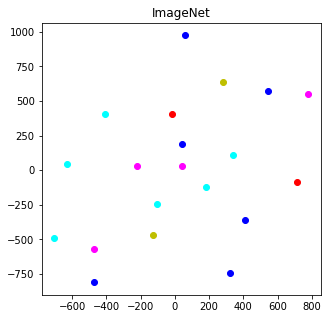

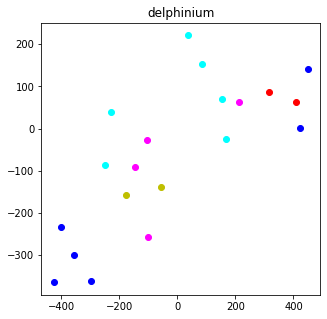

In [ ]:
############################################################
# Fit and transform with a TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=2) 

############################################################
# Project the data in 2D
imageNet_X_2d = tsne.fit_transform(imageNet_feats)
delphinium_X_2d = tsne.fit_transform(delphinium_feats)

############################################################
# Visualize the data
plt.figure(figsize=(5, 5))
for i in range(imageNet_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Lion's mane Jellyfish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 is Moon Jellyfish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Pacific Sea Nettle
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='b')
  if labels[i] == 3:

    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='cyan')
  if labels[i] == 4:

    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='y')
  if labels[i] == 5:
    # 3 is White spotted Jellyfish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='magenta')
plt.title('ImageNet')
# plt.show()

# Visualize the data
plt.figure(figsize=(5, 5))
for i in range(delphinium_X_2d.shape[0]):
  if labels[i] == 0:

    plt.scatter(delphinium_X_2d[i,0], delphinium_X_2d[i, 1], c='r')
  if labels[i] == 1:

    plt.scatter(delphinium_X_2d[i,0], delphinium_X_2d[i, 1], c='g')
  if labels[i] == 2:

    plt.scatter(delphinium_X_2d[i,0], delphinium_X_2d[i, 1], c='b')
  if labels[i] == 3:

    plt.scatter(delphinium_X_2d[i,0], delphinium_X_2d[i, 1], c='cyan')
  if labels[i] == 4:

    plt.scatter(delphinium_X_2d[i,0], delphinium_X_2d[i, 1], c='y')
  if labels[i] == 5:

    plt.scatter(delphinium_X_2d[i,0], delphinium_X_2d[i, 1], c='magenta')
plt.title('delphinium')

# plt.show()
plt.show()

In [ ]:
# Test the Trained Network


# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

# change value here to number of classes
for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.272232

Test Accuracy of     0: 93% (15/16)
Test Accuracy of     1: 90% (19/21)
Test Accuracy of     2: 100% (35/35)
Test Accuracy of     3: 96% (27/28)
Test Accuracy of     4: 77% (21/27)
Test Accuracy of     5: 98% (69/70)

Test Accuracy (Overall): 94% (186/197)


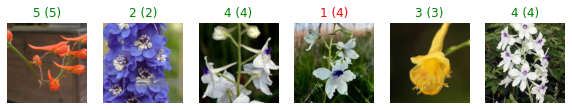

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,6), ncols=6)
for ii in range(6):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red"))